# Basic Forecasting
Using meta prophet, SARIMA, and SARIMAX for the Midlothian zillow and realtor housing costs data.

In [1]:
# Imports
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

C:\Users\steel\Desktop\School\Tamu\Tamu_2025_Fall\DAEN_429\Enviroment\daen429_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Grab and drop some collumns from the data
df = pd.read_csv("combined_data.csv")

# Supply and demand scores are 100% correlated with hotness score, drop them. Median listing price is very similar to the ZHVI score which is a modified
# median listing price. Tentatively drop it.
df = df.drop(["supply_score","demand_score", "median_listing_price"], axis = 1)

10:05:20 - cmdstanpy - INFO - Chain [1] start processing
10:05:21 - cmdstanpy - INFO - Chain [1] done processing


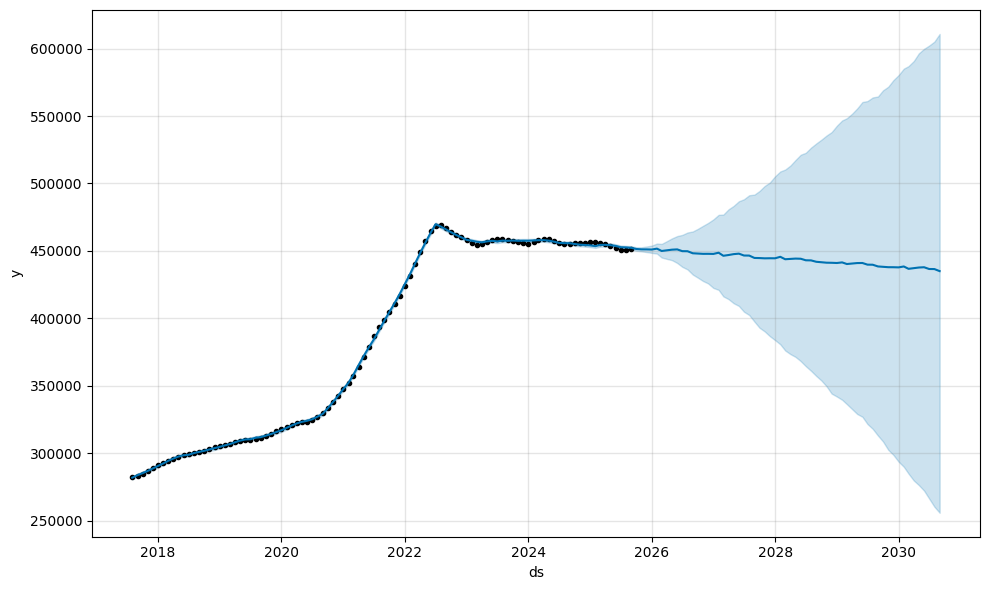

In [3]:
df_prophet = df.rename(columns={'observation_date': 'ds', 'ZHVI': 'y'})
model = Prophet()

model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Forecast 5 years
future = model.make_future_dataframe(periods=60, freq='ME')
forecast = model.predict(future)

model.plot(forecast)
plt.show()

# SARIMA(X)
## Find best hyper-parameters

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.set_index('observation_date')
df = df.asfreq('MS')  # monthly start frequency

In [5]:
import warnings
import itertools

warnings.filterwarnings("ignore")  # suppress convergence warnings

# Data prep (already done in your case)
# df.index = pd.DatetimeIndex, freq='MS', df['ZHVI'] is target

p = q = range(0, 3)
d = [1]
P = Q = range(0, 2)
D = [1]
s = 12  # monthly seasonality

best_aic = float('inf')
best_order = None
best_seasonal = None
best_model = None

# Grid search
for order in itertools.product(p, d, q):
    for seasonal in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                df['ZHVI'],
                order=order,
                seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False, maxiter=300)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal = seasonal
                best_model = results
                print(f"New best AIC {best_aic:.1f} | order={order} seasonal={seasonal}")
        except Exception:
            continue

print("\n=== BEST MODEL ===")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal)
print("AIC:", best_aic)

New best AIC 1619.1 | order=(0, 1, 0) seasonal=(0, 1, 0)
New best AIC 1398.2 | order=(0, 1, 0) seasonal=(0, 1, 1)
New best AIC 1327.1 | order=(0, 1, 1) seasonal=(0, 1, 1)
New best AIC 1280.9 | order=(0, 1, 2) seasonal=(0, 1, 1)
New best AIC 1226.6 | order=(1, 1, 0) seasonal=(0, 1, 1)
New best AIC 1220.3 | order=(1, 1, 0) seasonal=(1, 1, 0)
New best AIC 1190.6 | order=(1, 1, 1) seasonal=(0, 1, 1)
New best AIC 1187.8 | order=(1, 1, 1) seasonal=(1, 1, 1)
New best AIC 1140.0 | order=(1, 1, 2) seasonal=(0, 1, 1)
New best AIC 1137.1 | order=(1, 1, 2) seasonal=(1, 1, 1)
New best AIC 1133.4 | order=(2, 1, 2) seasonal=(0, 1, 1)
New best AIC 1132.3 | order=(2, 1, 2) seasonal=(1, 1, 1)

=== BEST MODEL ===
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1)
AIC: 1132.325402701963


## Compare SARIMA and SARIMAX (aka with and without extra features)

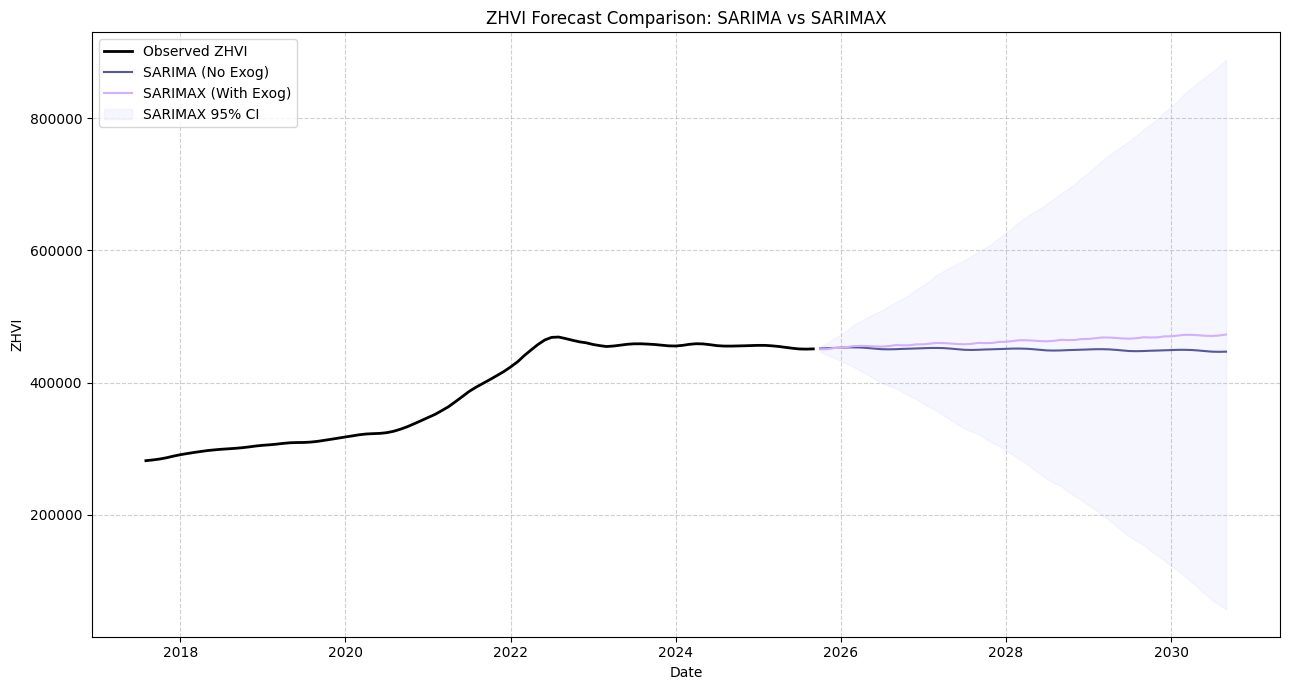


--- SARIMA Summary ---
                                      SARIMAX Results                                       
Dep. Variable:                                 ZHVI   No. Observations:                   98
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -559.163
Date:                              Mon, 03 Nov 2025   AIC                           1132.325
Time:                                      10:05:30   BIC                           1148.065
Sample:                                  08-01-2017   HQIC                          1138.577
                                       - 09-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2565      0.131      9.589      0.000       1.000       1

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df['ZHVI']
X = df[['DFF', 'cpi', 'mortgage', 'hotness_score']]

future_steps = 60  # 5 years ahead

# Do the univariate version
sarima_model = SARIMAX(y, order=(2,1,2), seasonal_order=(1,1,1,12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit(maxiter=500, disp=False)
sarima_forecast = sarima_results.get_forecast(steps=future_steps)
sarima_df = sarima_forecast.summary_frame()

# To include the other features first forecast those
exog_forecasts = {}
for col in X.columns:
    model_exog = SARIMAX(X[col], order=(2,1,2), seasonal_order=(0,0,0,12),
                         enforce_stationarity=False, enforce_invertibility=False)
    results_exog = model_exog.fit(disp=False)
    forecast_exog = results_exog.get_forecast(steps=future_steps).predicted_mean
    exog_forecasts[col] = forecast_exog

# Combine 
exog_future = pd.DataFrame(exog_forecasts)

# Do the forecast again but this time with the extra values
sarimax_model = SARIMAX(y, exog=X, order=(2,1,2), seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_results = sarimax_model.fit(maxiter=500, disp=False)
sarimax_forecast = sarimax_results.get_forecast(steps=future_steps, exog=exog_future)
sarimax_df = sarimax_forecast.summary_frame()

# Plot out the results
plt.figure(figsize=(13,7))
plt.plot(y.index, y, label='Observed ZHVI', color='black', linewidth=2)
plt.plot(sarima_df.index, sarima_df['mean'], label='SARIMA (No Exog)', color='#575799')
plt.plot(sarimax_df.index, sarimax_df['mean'], label='SARIMAX (With Exog)', color='#d2afff')
plt.fill_between(sarimax_df.index, sarimax_df['mean_ci_lower'], sarimax_df['mean_ci_upper'],
                 color='#D3D3FF', alpha=0.2, label='SARIMAX 95% CI')
plt.title('ZHVI Forecast Comparison: SARIMA vs SARIMAX')
plt.xlabel('Date')
plt.ylabel('ZHVI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 
print("\n--- SARIMA Summary ---")
print(sarima_results.summary())
print("\n--- SARIMAX Summary ---")
print(sarimax_results.summary())


In [10]:
#AIC % difference:
diff = (1264.833/1132.577 * 100) - 100

print(f"Base SARIMA is {diff:.2f}% better than the SARIMAX model when comparing the amount of trends and variance each model explains.")

Base SARIMA is 11.68% better than the SARIMAX model when comparing the amount of trends and variance each model explains.


## Compare SARIMA and Prophet

In [8]:
import numpy as np

10:05:30 - cmdstanpy - INFO - Chain [1] start processing
10:05:31 - cmdstanpy - INFO - Chain [1] done processing


SARIMA | RMSE: 50249.54 | MAE: 42176.02
Prophet | RMSE: 10647.73 | MAE: 9815.74


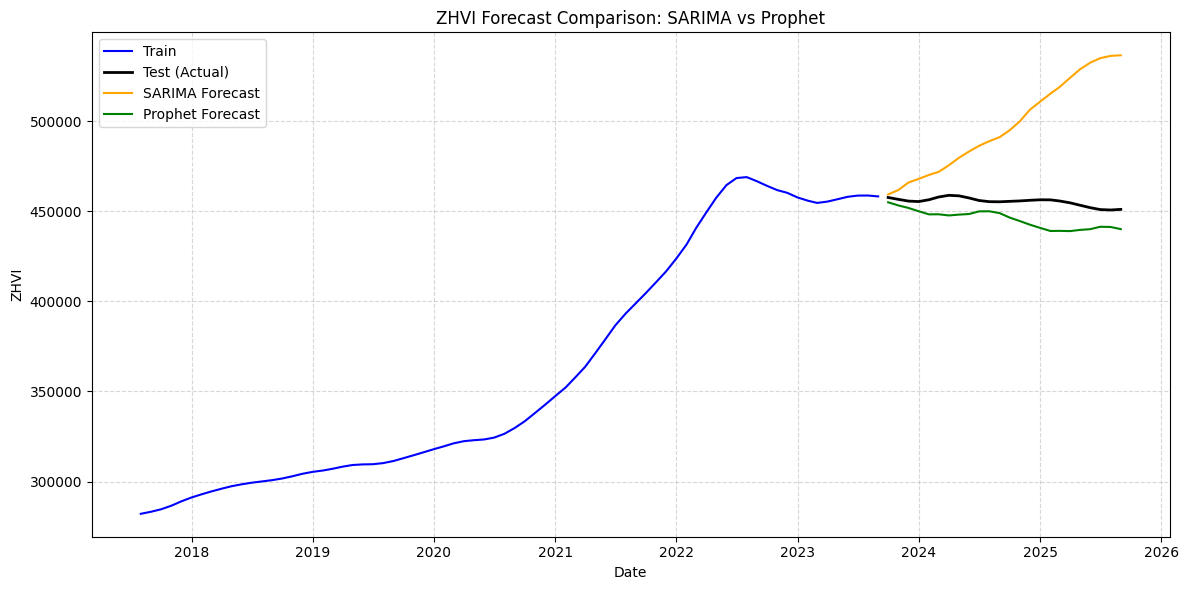

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Train/test split
test_months = 24  # last 2 years as test
train = df.iloc[:-test_months]
test = df.iloc[-test_months:]

y_train = train['ZHVI']
y_test = test['ZHVI']

#Sarima
order = (2,1,2)
seasonal_order = (1,1,1,12)

sarima_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

# Forecast test period
sarima_forecast = sarima_results.get_forecast(steps=test_months)
sarima_pred = sarima_forecast.predicted_mean

# Prophet
prophet_train = train.reset_index()[['observation_date','ZHVI']].rename(columns={'observation_date':'ds', 'ZHVI':'y'})
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(prophet_train)

# Make future dataframe
future_dates = prophet_model.make_future_dataframe(periods=test_months, freq='MS')
prophet_forecast = prophet_model.predict(future_dates)
prophet_pred = prophet_forecast.set_index('ds')['yhat'][-test_months:]

# Compute metrics
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

evaluate(y_test, sarima_pred, "SARIMA")
evaluate(y_test, prophet_pred, "Prophet")

# Plot them
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='Test (Actual)', color='black', linewidth=2)
plt.plot(y_test.index, sarima_pred, label='SARIMA Forecast', color='orange')
plt.plot(y_test.index, prophet_pred, label='Prophet Forecast', color='green')
plt.title('ZHVI Forecast Comparison: SARIMA vs Prophet')
plt.xlabel('Date')
plt.ylabel('ZHVI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Overall Outcomes
1. On the full dataset Prophet predicts house prices to lower slightly faster than the SARIMA(X) models.
2. Between the two versions of SARIMA, the one without extra values continues the slight downward trend of house prices; But with the addtional features in the model, this drags us up and predicts an increase in house prices. As expected with CPI being a stand-in for inflation? But the prices do not rise as fast as we have the FEDFUNDS rate lowering which would lower the cost of housing. Overall the model without the extra features has a lower AIC by about 11% which means it better explains the trends and variance of the data.
3. The comparison between prophet and SARIMA at the end is slightly unfair as SARIMA did not have a long enough period of flat-lining values to ad-here to. It does show that the prophet model is better at predicting the actual values though.
4. Actual performance of the models is difficult to quanitfy as outside confounding factors make up a large portion of how the housing market changes, see the trend shown in the data for Midlothian.